## Miyamoto Nagai disk
The Miyamoto Nagai potential is

$$
    \Phi(r,z) = -\dfrac{GM}{\sqrt{r^2 + \left(\sqrt{z^2+b^2}+a\right)^2}}
$$

And we can plot it in terms of $z/a$ and $R/a$

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import animation
from tqdm.notebook import tqdm
from IPython.display import HTML

plt.style.use('../../sim.mplstyle')
%config InlineBackend.figure_format = 'retina'

In [2]:
def phi(r,z,a,b):
    return -1/(np.sqrt(r**2 + (np.sqrt(z**2+b**2) + a)**2))

$b/a \gg 1$ gives a spherical distribution, $b/a \ll 1$ gives a flattened distribution

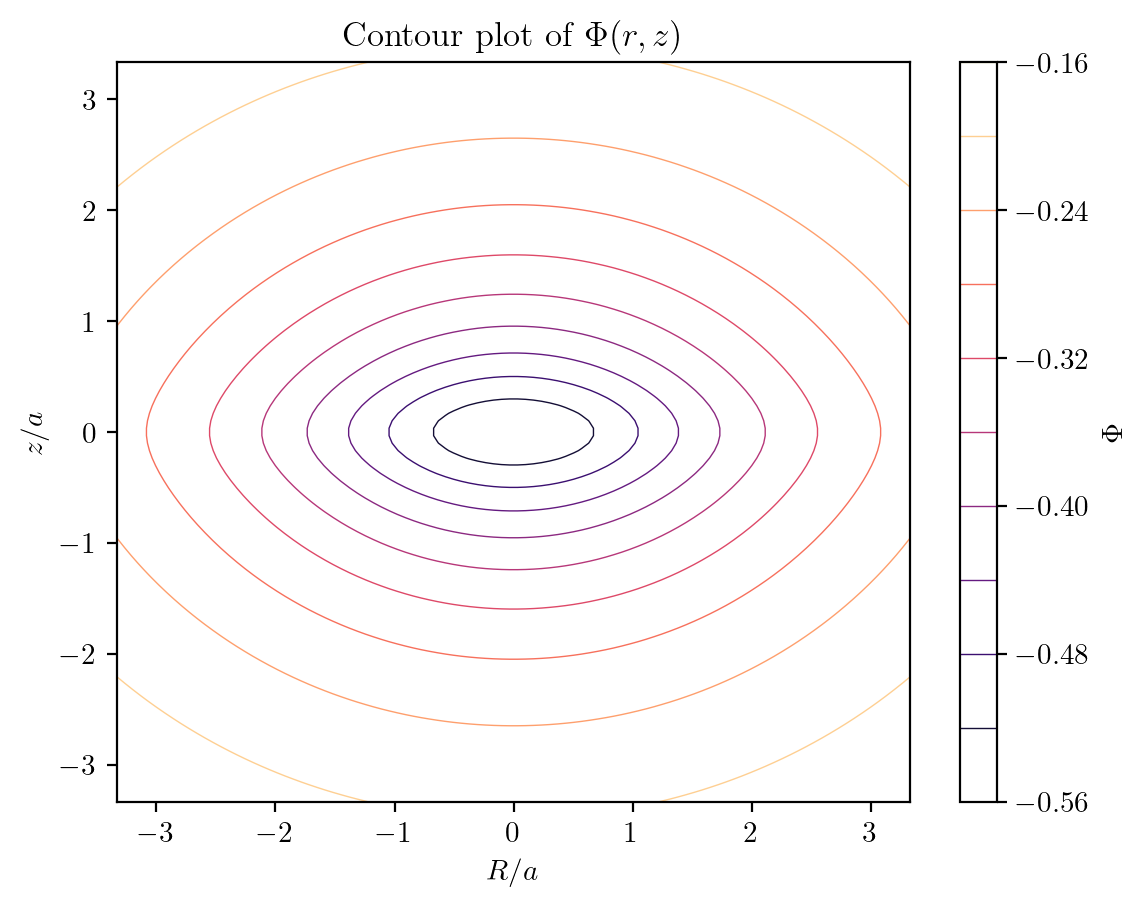

In [3]:
r = np.linspace(-5, 5, 100)
z = np.linspace(-5, 5, 100)
R, Z = np.meshgrid(r, z)

#constants
M = 1
G = 1
ratio = 0.2
a = 1.5
b = ratio*a

# Compute phi over the grid
Phi = phi(R/a, Z/a, a, b)

# Create the contour plot
plt.contour(R/a, Z/a, Phi, 10)
plt.xlabel(r'$R/a$')
plt.ylabel(r'$z/a$')
plt.colorbar(label=r'$\Phi$')
plt.title(r'Contour plot of $\Phi(r, z)$')
plt.show()

Using the Poisson equation yields

$$
     \rho(R, z) = \left( \frac{b^2 M_\mathrm{tot}}{4 \pi} \right) \frac{a R^2 + \left( 3 \sqrt{z^2 + b^2} + a \right) \left( \sqrt{z^2 + b^2} + a \right)^2}{\left( R^2 + \left( \sqrt{z^2 + b^2} + a \right)^2 \right)^{5/2} \left( z^2 + b^2 \right)^{3/2}}.
$$

<br>

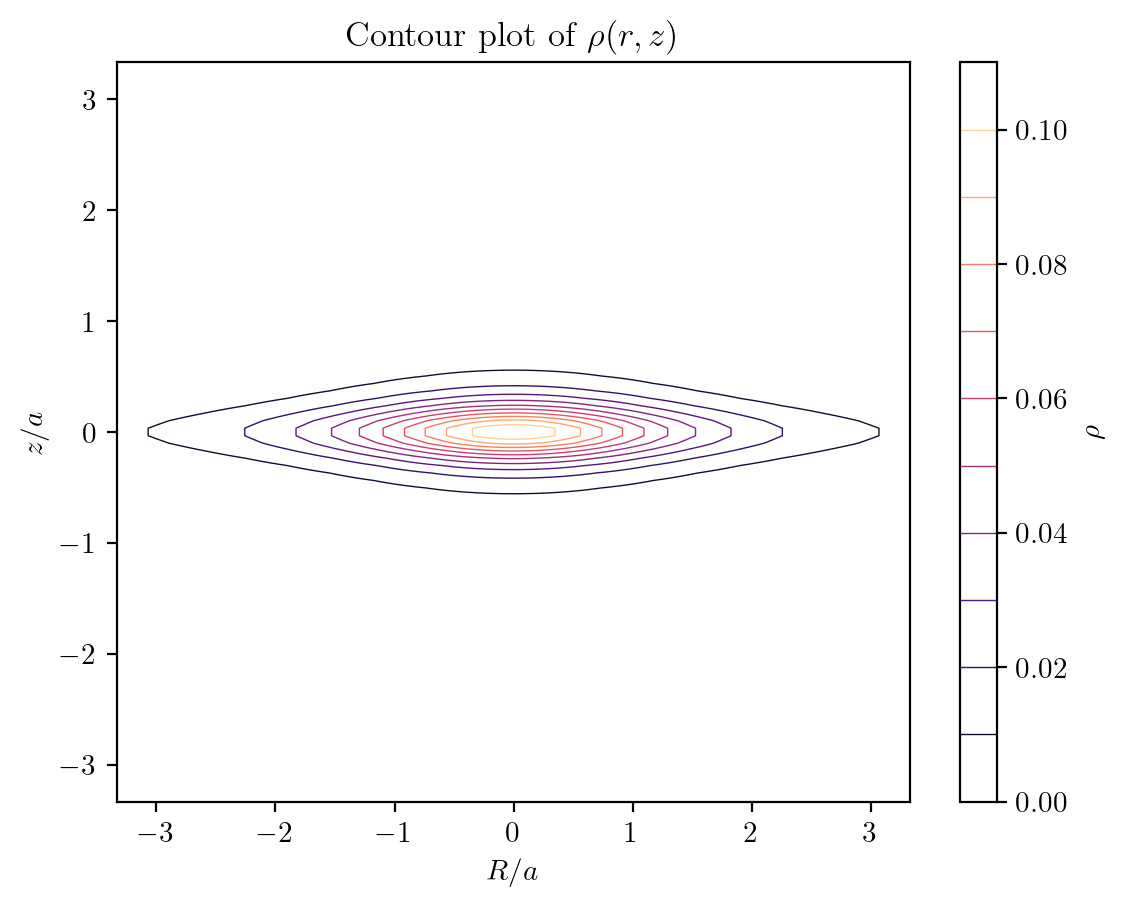

In [4]:
# Define the density function
def density(R, z):
    term1 = (b**2 * M) / (4 * np.pi)
    term2 = a * R**2 + (3 * np.sqrt(z**2 + b**2) + a) * (np.sqrt(z**2 + b**2) + a)**2
    term3 = (R**2 + (np.sqrt(z**2 + b**2) + a)**2)**(5/2)
    term4 = (z**2 + b**2)**(3/2)
    return term1 * term2 / (term3 * term4)


# Create the contour plot
plt.contour(R/a, Z/a, density(R/a,Z/a), 10)
plt.xlabel(r'$R/a$')
plt.ylabel(r'$z/a$')
plt.colorbar(label=r'$\rho$')
plt.title(r'Contour plot of $\rho(r, z)$')
plt.show()

To initialize the Miyamoto-Nagai disk, we need to set the correct distributions for the particles' Cartesian coordinates. We will first find the distributions in cylindrical coordinates and then project them onto the Cartesian plane.

#### Mass Distribution

The mass enclosed within a radius \( r \) in cylindrical coordinates is:

$$
M(r) = \int_0^r \int_{-\infty}^{\infty} \int_0^{2\pi} \rho(R, z) R \, d\phi \, dz \, dR
$$

Where we also used that $dV = Rd\phi drdz$.

For our Monte Carlo approach we need to deal with probability distributions directly.

#### Radial Distribution

The cumulative distribution function (CDF) for the radial distance $R$ is:

$$
P(R) = \frac{M(R)}{M_{\text{total}}} = \frac{1}{M_{\text{total}}} \int_0^R \int_{-\infty}^{\infty} \int_0^{2\pi} \rho(R', z) R' \, d\phi \, dz \, dR'
$$

<br>

The probability density function (PDF) for the radial distance is, for the fundamental theorem of algebra:

<br>


$$
p(R) = \frac{dP(R)}{dR} = \frac{1}{M_{\text{total}}} \int_{-\infty}^{\infty} \int_0^{2\pi} \rho(R, z) R \, d\phi \, dz
$$

#### Azimuthal Distribution

Since the Miyamoto-Nagai potential is axisymmetric (independent of $\phi$), the azimuthal angle $\phi$ is uniformly distributed:

$$
P(\phi) = \frac{\phi}{2\pi}, \quad p(\phi) = \frac{1}{2\pi}
$$

#### Vertical Distribution

The distribution of $ z $ (or equivalently the polar angle $ \theta $) needs to account for the density profile. In cylindrical coordinates, $ z = r \cos \theta $.

The CDF for $ z $ is:

$$
P(z) = \frac{1}{M_{\text{total}}} \int_{-\infty}^z \int_0^\infty \int_0^{2\pi} \rho(R, z') R \, d\phi \, dR \, dz'
$$

The PDF for $ z $ is:

$$
p(z) = \frac{dP(z)}{dz} = \frac{1}{M_{\text{total}}} \int_0^\infty \int_0^{2\pi} \rho(R, z) R \, d\phi \, dR
$$

### Summary

To initialize the Miyamoto-Nagai disk, we follow these steps:

- Compute the radial CDF $ P(R) $ and PDF $ p(R) $.

- Use the uniform distribution $ p(\phi) $.

- Compute the vertical CDF $ P(z) $ and PDF $ p(z) $.

Using these distributions, we can sample the cylindrical coordinates $ (R, \phi, z) $ and then convert them to Cartesian coordinates for our simulations.

### Implementation
Integrating the density analytically is impossible, we would need to use numerical integration and then use interpolation to find the inverse of the CDF. Another possibility is instead to evaluate the pdf only and then use rejection method.

In [5]:
import sys
sys.path.insert(1, '../')
from gdsam import initial_data

In [6]:
disk = initial_data()
N = int(5e3)

### Rejection sampling

In [89]:
def pdf(r,z):
    return 1/M*density(r,z)

r_range = np.linspace(0,1,100)
z_range = np.linspace(-1,1,100)

R,Z = np.meshgrid(r_range, z_range)

g = np.max(pdf(R,Z))

print(f'the maximum of the distribution is {g:.3f}')

the maximum of the distribution is 0.109


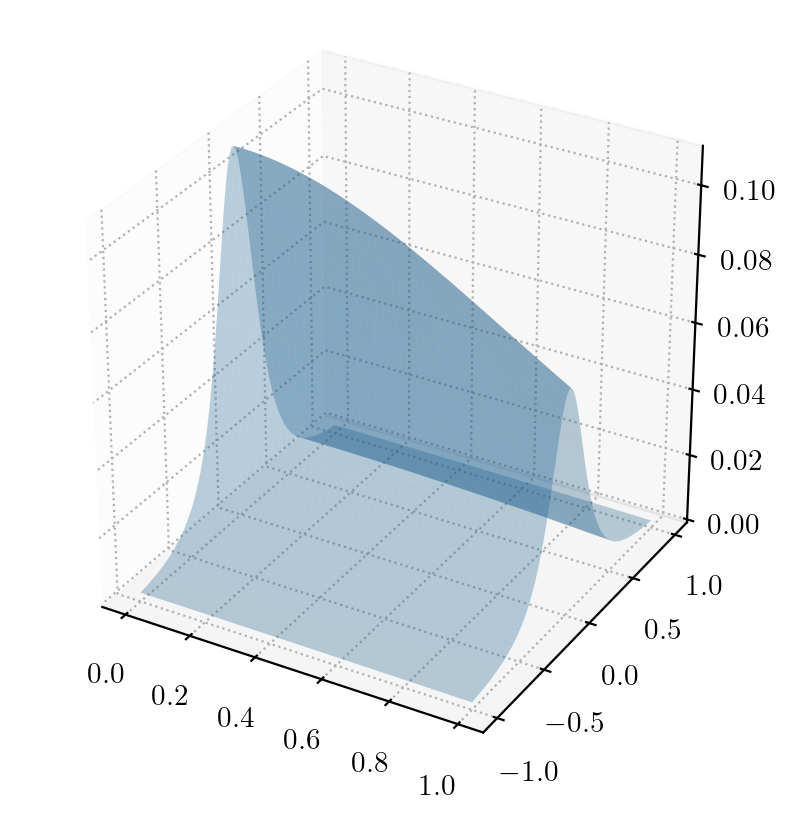

In [85]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d", "aspect":"equal"})

ax.plot_surface(R,Z, pdf(R,Z), alpha=0.3);

Since the probability is almost 0 outside the range shown we can perform a rejection sampling that's limited in range.

In [103]:
#rejection method

# Define the envelope function g(R, z)
def envelope(R, z):
    return 1.0

def rejection_sampling(density_func, envelope_func, R_max, z_max, num_samples):
    samples = []
    with tqdm(total=num_samples, desc='Sampling') as pbar:
        while len(samples) < num_samples:
            # Generate candidate samples
            R_i = np.random.uniform(0, R_max)
            z_i = np.random.uniform(-z_max, z_max)
            u = np.random.uniform(0, 1)
            
            # Accept or reject the candidate
            if u < pdf(R_i, z_i) / envelope(R_i, z_i):
                samples.append((R_i, z_i))
                pbar.update(1)
                
    return np.array(samples)

R_max = 10
z_max = 5
num_samples = N

samples = rejection_sampling(density, envelope, R_max, z_max, num_samples)

R_samples = samples[:, 0]
z_samples = samples[:, 1]

Sampling:   0%|          | 0/5000 [00:00<?, ?it/s]

In [104]:
disk.N = N
disk.m = np.full(N, M / N)
disk.r = R_samples
disk.z = z_samples
disk.theta = 2*np.pi*np.random.uniform(0,1,N)

disk.x = disk.r * np.cos(disk.theta)
disk.y = disk.r * np.sin(disk.theta)
disk.z = disk.z

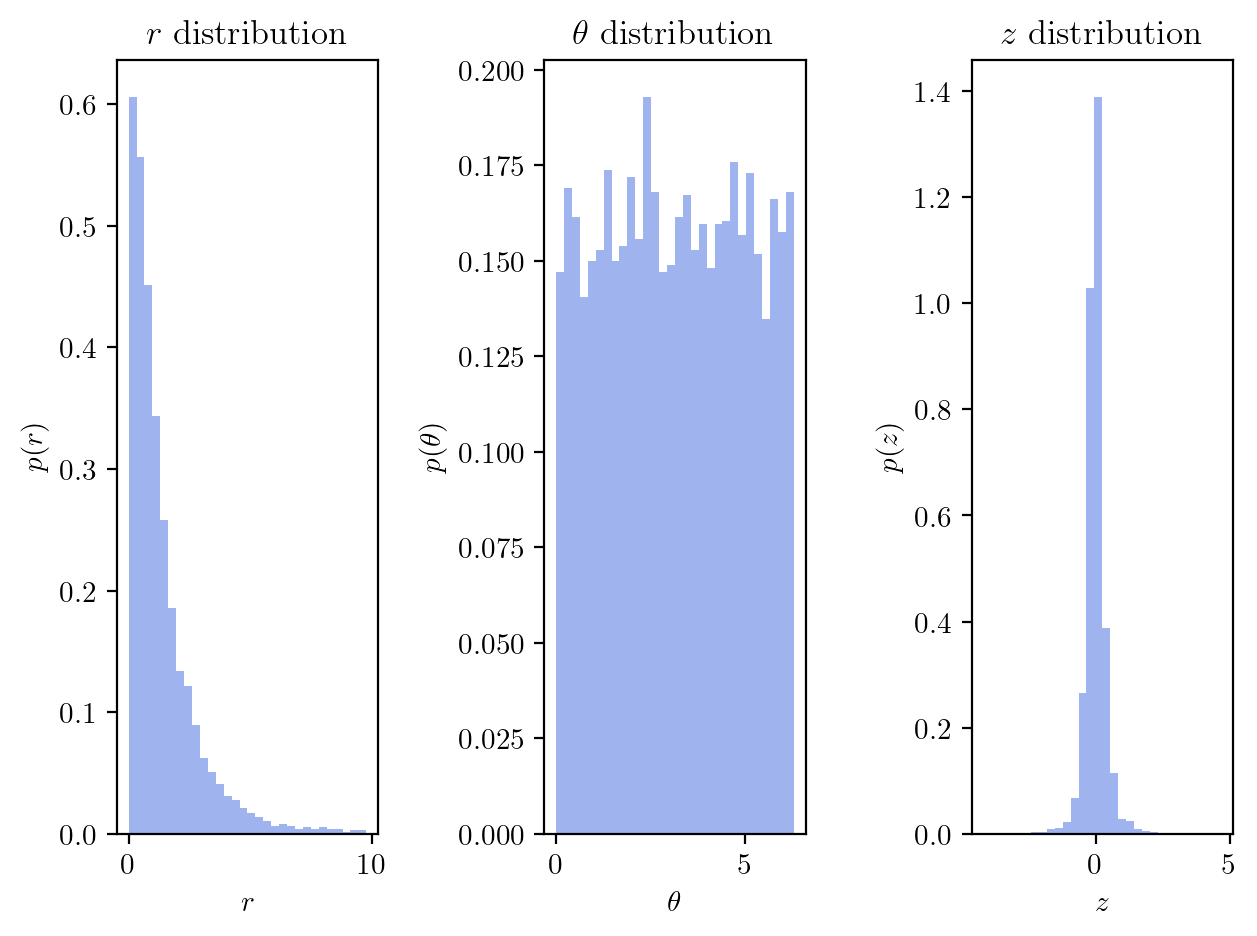

In [105]:
disk.show_dist_cyl()

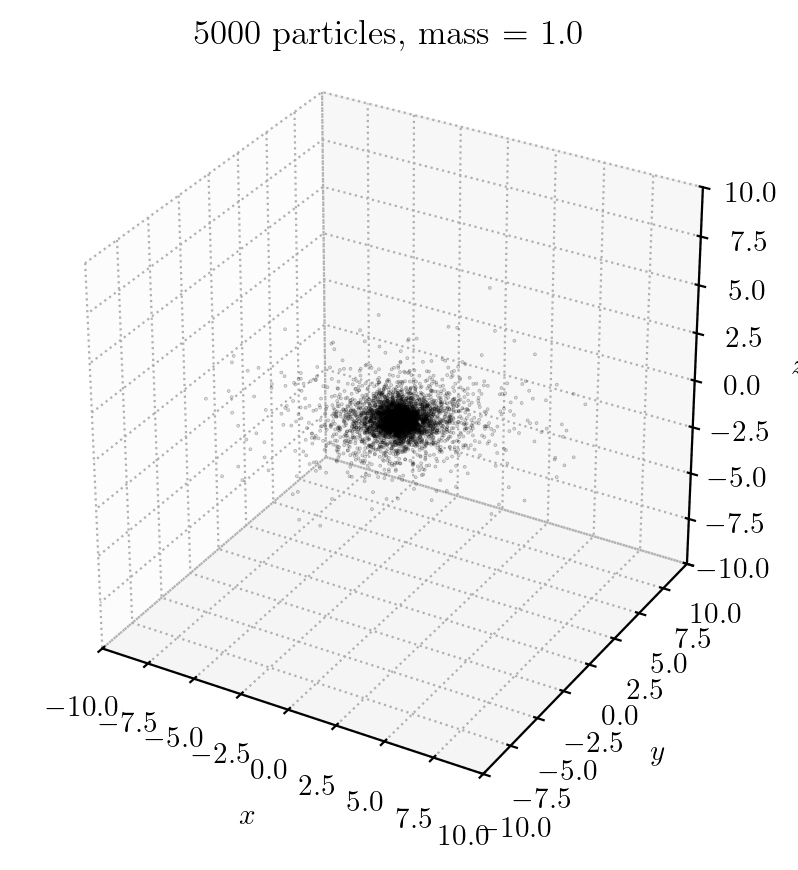

In [106]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
disk.positions_3d(ax, l=10, s=.1, a=.3)

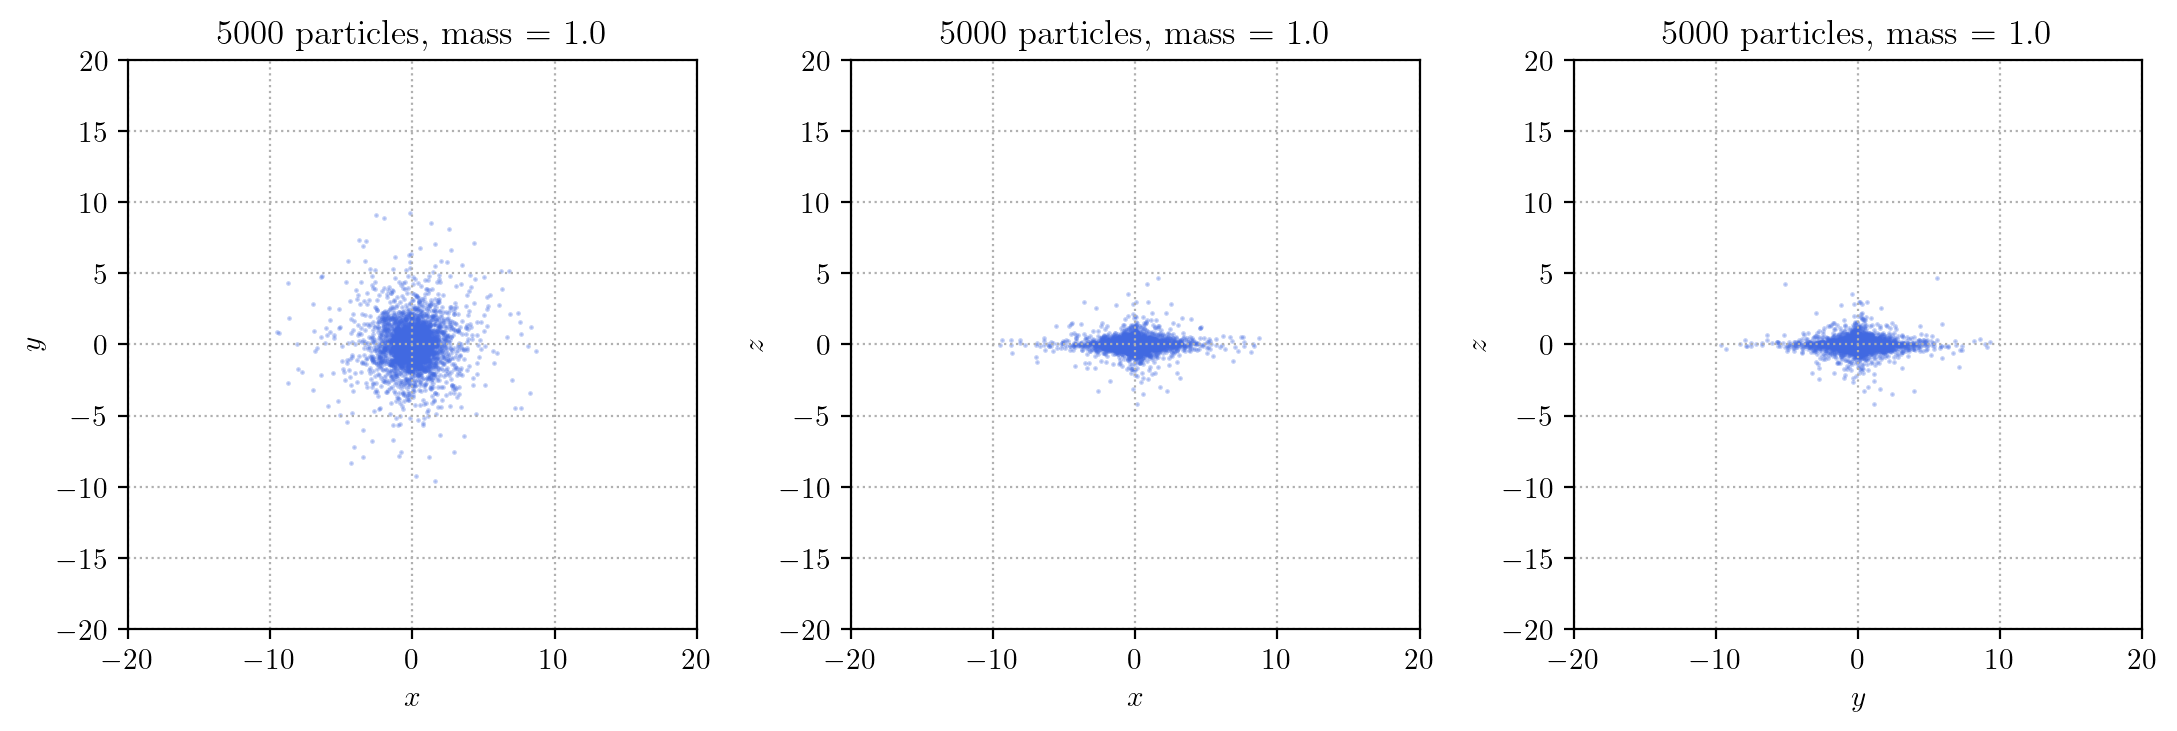

In [107]:
disk.projections(l=20, s=.5, a=.3);

---

In [140]:
home = '../../'
input = home + f'data/inputs/MN-disk{N}.txt' 
output = home + f'data/outputs/MN-disk{N}.txt'
log = f'../../data/outputs/MN-disk{N}_log.txt'

In [141]:
disk.initialize_velocities()

In [142]:
open(output, 'w').close() #clearing output file
disk.write_tree(input)

Now we calculate the softening and accuracy parameters. The softening must be calculated for the volume of the disk. We know the density is the mass per unit volume, so the volume will be the given by

$$
    V = \dfrac{M_\mathrm{tot}}{\rho_\mathrm{tot}} = \dfrac{1}{\mathrm{pdf}(R,Z)}
$$

where $R,Z$ represent the maximum radius and height of the distribution

In [143]:
R = np.max(disk.r)
Z = np.max(disk.z)

V = 1/pdf(R,Z)
print(f'{V:.2e}')

4.01e+06


In [144]:
epsilon = 1/100 * (V/int(float(N)))**(1/3)
print(f'{epsilon:.3f}')

0.093


In [145]:
T_sim = 400
dt = 0.5
theta = 0.1

In [146]:
print(f'T_sim = {T_sim:.1f} \t epsilon = {epsilon:.2e} \t dt = {dt:.2f}')

T_sim = 400.0 	 epsilon = 9.29e-02 	 dt = 0.50


In [147]:
os.system(home + f'treecode/tree/treecode in={input} out={output} eps={epsilon} tstop={T_sim} dtout={dt}>{log}')

0

In [148]:
import gdsam

pl = gdsam.plotter()
pl.get_data_tree(output)

Loaded 5e+03 particles


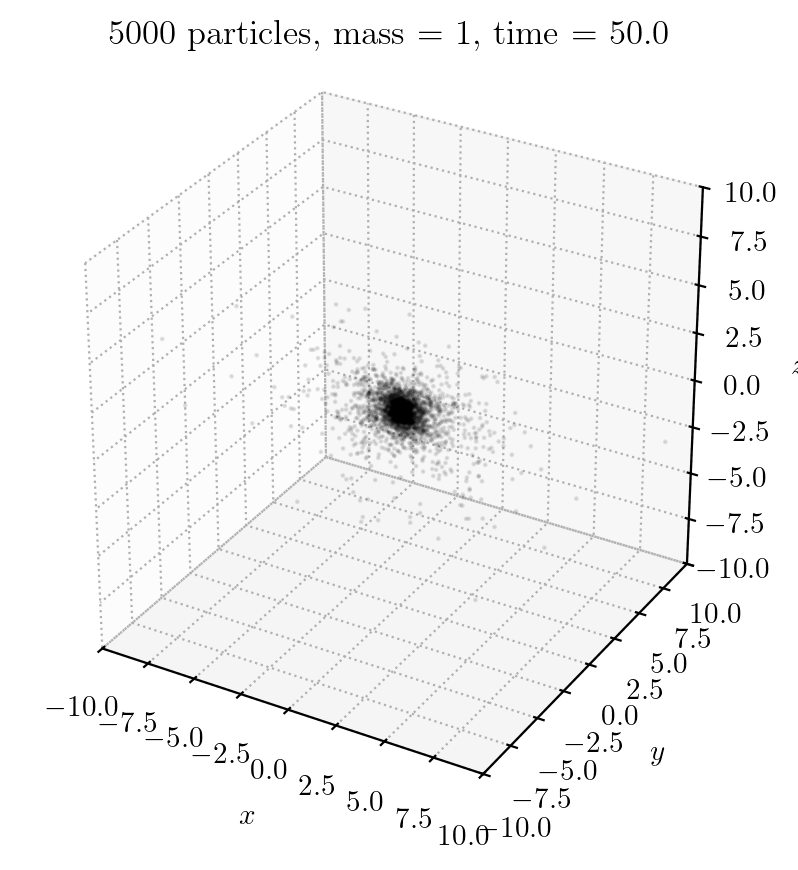

In [149]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
i = 100

x_cm, y_cm ,z_cm = pl.x_cm, pl.y_cm, pl.z_cm
pl.positions_3d(ax, num=i, l=10, b=0, a=.1, s=.5)
ax.scatter(x_cm[i], y_cm[i], z_cm[i], s=20, c='r');

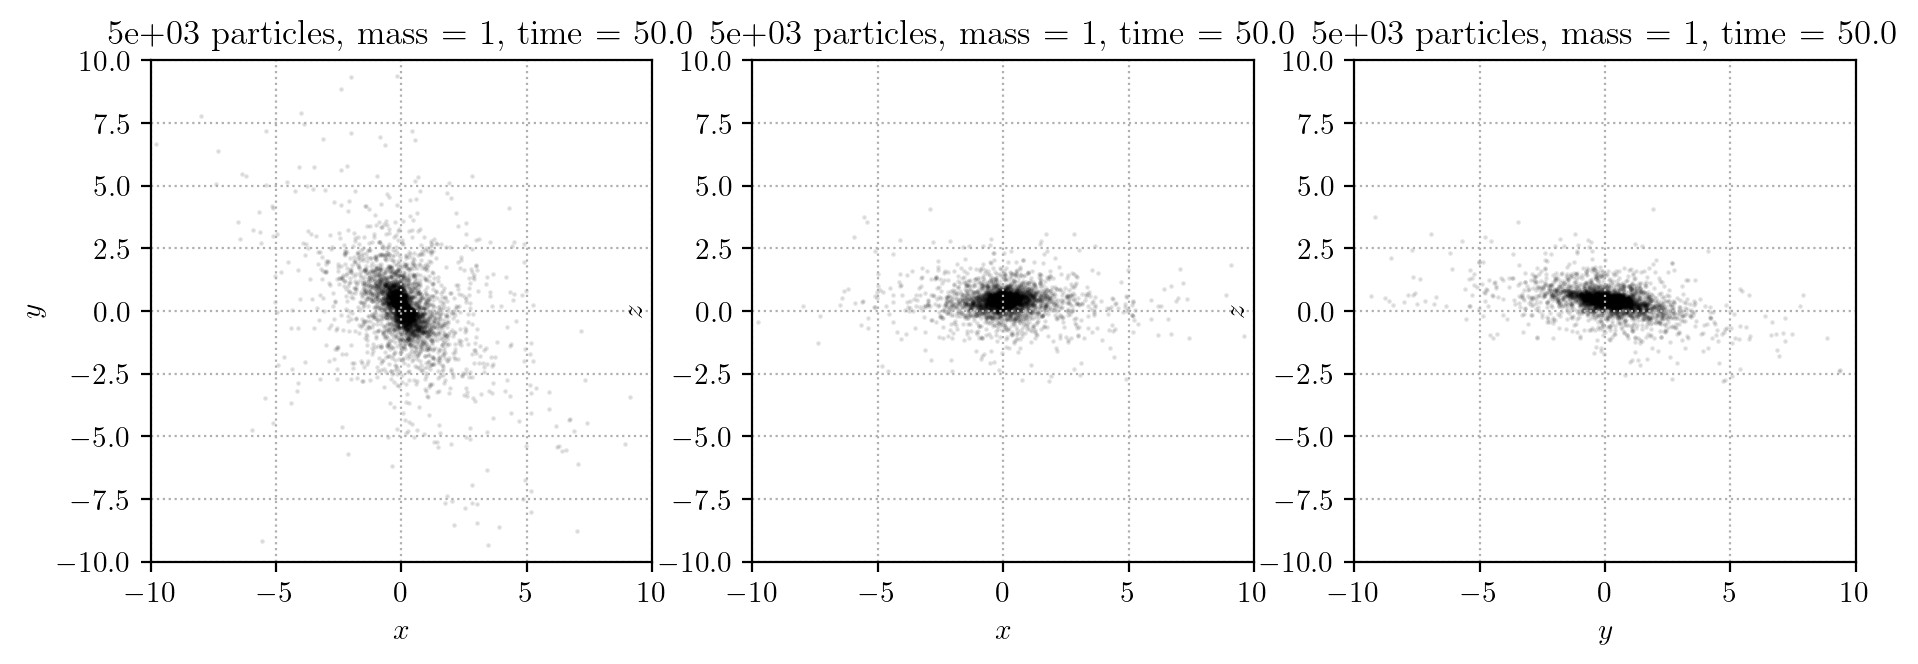

In [150]:
pl.projections(num=i, s=.5, a=.1, b=0, l=10);

  0%|          | 0/401 [00:00<?, ?it/s]

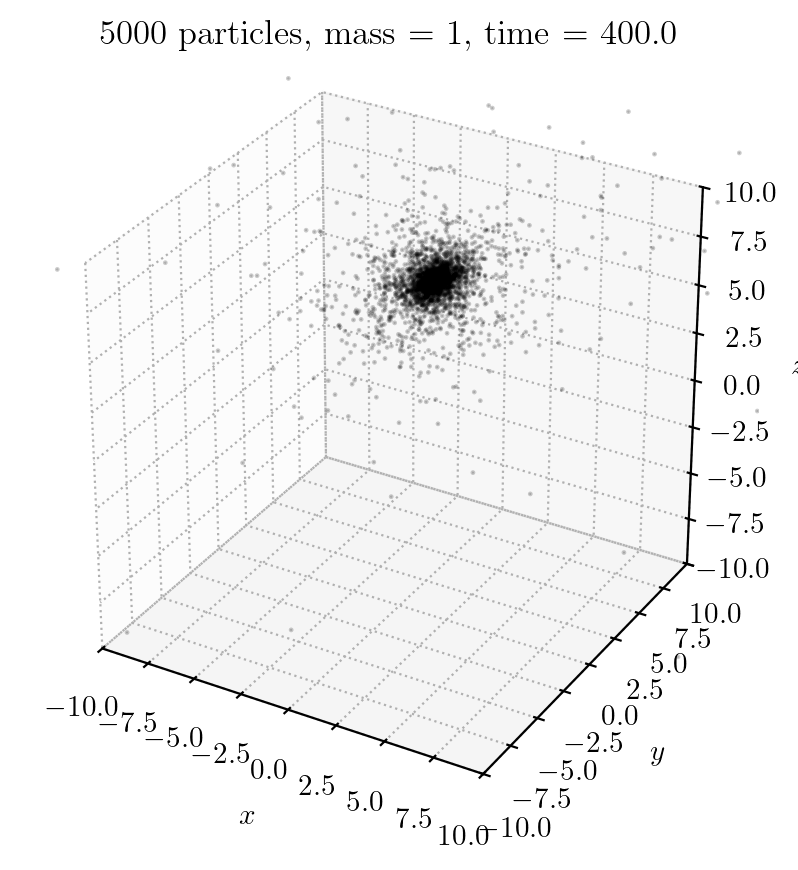

In [151]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ani = pl.animate_3d(fig, ax, b=0, l=10, s=.5, a=.1, frame_skip=2)

ani.save(f'../media/disk{N}.mp4', dpi=300, fps=30)

In [152]:
from IPython.display import Video

Video(filename=f'../media/disk{N}.mp4', width=600)